In [52]:
#importing our libraries 

In [51]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Loading Data 

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('path to db') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

('Number of data points in our data', (525814, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data cleaning - duplications

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64


# Text pre-processing - stemming stopwords lemmintizations

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('/home/ajay/Applied_course/amazon_datas/final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('/home/ajay/Applied_course/amazon_datas/positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('/home/ajay/Applied_course/amazon_datas/negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [13]:
if os.path.isfile('path to db'):
    conn = sqlite3.connect('path to db')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [14]:
final.shape

(364171, 12)

In [15]:
final.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


# 1. Bag of Words 

In [16]:
# i am using only 4000 rows for analysis since my ram config is 8 Gb 

final_data = final[0:4000]
final_data.shape

(4000, 12)

In [17]:
final_data['Score'].value_counts()

positive    3342
negative     658
Name: Score, dtype: int64

In [18]:
final_data['CleanedText'].values.shape

(4000,)

In [19]:
#Bag of words
count_vect = CountVectorizer(min_df=10)
final_vect = count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_vect))
print("the shape of out text BOW vectorizer ",final_vect.get_shape())
print("the number of unique words ", final_vect.get_shape()[1])

('the type of count vectorizer ', <class 'scipy.sparse.csr.csr_matrix'>)
('the shape of out text BOW vectorizer ', (4000, 2018))
('the number of unique words ', 2018)


In [20]:
#Since our matrix is sparse matrix so procced with tsne we need to convert it into dense matrix
final_vect = final_vect.todense()

In [21]:
final_vect.shape

(4000, 2018)

In [22]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_vect)
print(standardized_data.shape)

(4000, 2018)


# T-sne of bow

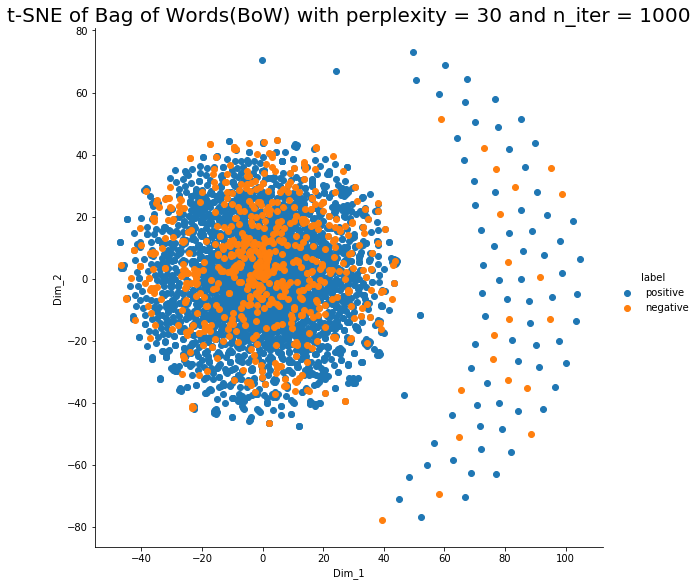

In [23]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(standardized_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 30 and n_iter = 1000',size=20)
plt.show()

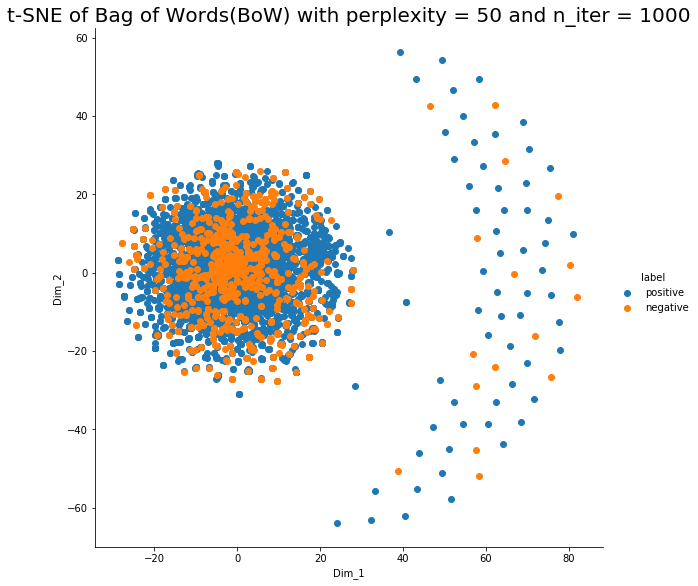

In [24]:
# t-SNE with perplexity = 50 and n_iter = 1000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 1000',size=20)
plt.show()

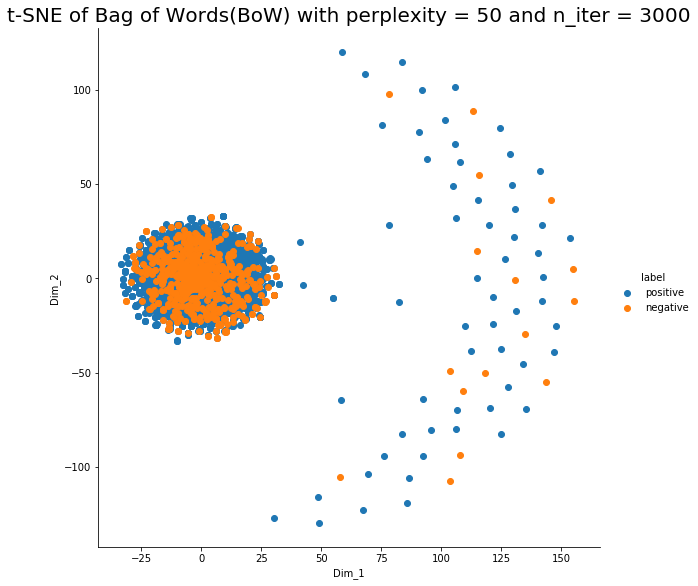

In [26]:
# t-SNE with perplexity = 50 and n_iter = 2000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

Observations:
    So after plotting tsne for differennt values of perplexity and n_iter its clearly observed thar most of are overlapping

# Bi-grams

In [27]:
#Bi-Gram
count_vect = CountVectorizer(ngram_range=(1,2),min_df=5 ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

('the type of count vectorizer ', <class 'scipy.sparse.csr.csr_matrix'>)
('the shape of out text BOW vectorizer ', (4000, 6377))
('the number of unique words including both unigrams and bigrams ', 6377)


In [28]:
#change sparse matrix to dense matrix
final_bigram_counts = final_bigram_counts.todense()

In [29]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_bigram_counts)
print(standardized_data.shape)

(4000, 6377)


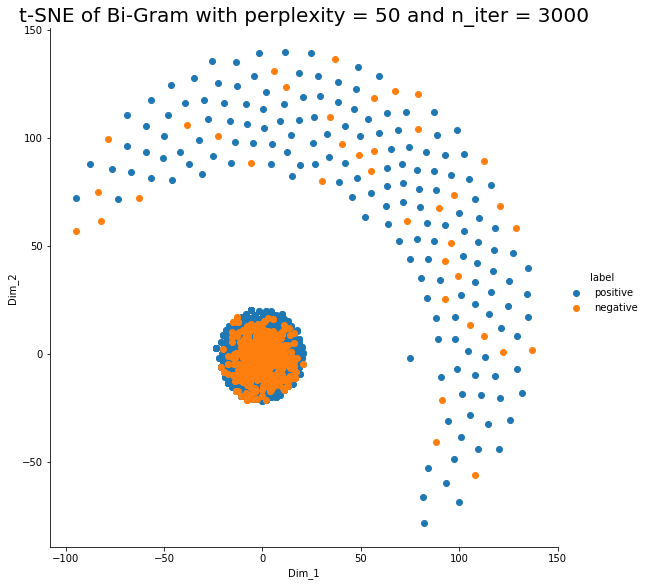

In [30]:
from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bi-Gram with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

Observations: It is clear from above plot that data are overlapping almost

# TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
final_tf_idf = tf_idf_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

('the type of count vectorizer ', <class 'scipy.sparse.csr.csr_matrix'>)
('the shape of out text TFIDF vectorizer ', (4000, 6377))
('the number of unique words including both unigrams and bigrams ', 6377)


In [32]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1000:1010])

('some sample features(unique words in the corpus)', [u'cold winter', u'collect', u'colleg', u'colli', u'color', u'color dont', u'color ice', u'color like', u'color littl', u'color make'])


In [33]:
#change sparse matrix to dense matrix
final_tf_idf = final_tf_idf.toarray()

In [34]:
final_tf_idf.shape

(4000, 6377)

In [35]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_tf_idf)
print(standardized_data.shape)

(4000, 6377)


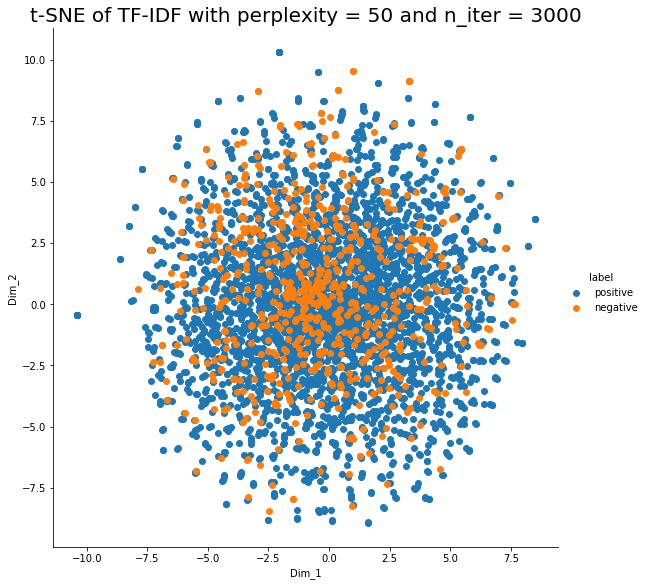

CPU times: user 5min 19s, sys: 4.65 s, total: 5min 24s
Wall time: 5min 21s


In [36]:
%%time
from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TF-IDF with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

Observations: It is clearly from above plot that data are overlapping

# Word2vec

In [37]:
# Train our own Word2Vec model using our own text corpus
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [38]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
[u'witti', u'littl', u'book', u'make', u'son', u'laugh', u'loud', u'recit', u'car', u'drive', u'along', u'alway', u'sing', u'refrain', u'hes', u'learn', u'whale', u'india', u'droop', u'love', u'new', u'word', u'book', u'introduc', u'silli', u'classic', u'book', u'will', u'bet', u'son', u'still', u'abl', u'recit', u'memori', u'colleg']


In [39]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

('number of words that occured minimum 5 times ', 3264)


# Avg word2vec

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


In [42]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(4000, 50)


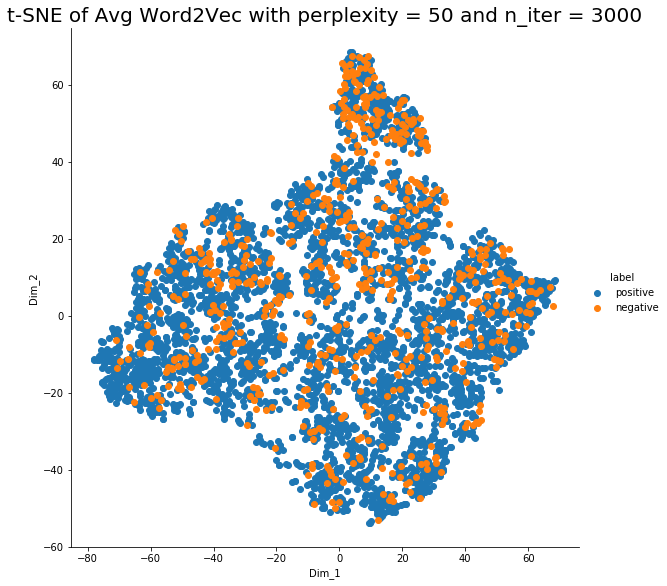

In [43]:
from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Avg Word2Vec with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

Observations: It is clearly from above plot the data are overlapping and but it is better from other above plot

# TF-IDF Word2vec

In [45]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_data['CleanedText'].values)

In [46]:
final_tf_idf.shape

(4000, 9492)

In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [48]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [49]:
#  Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(4000, 50)


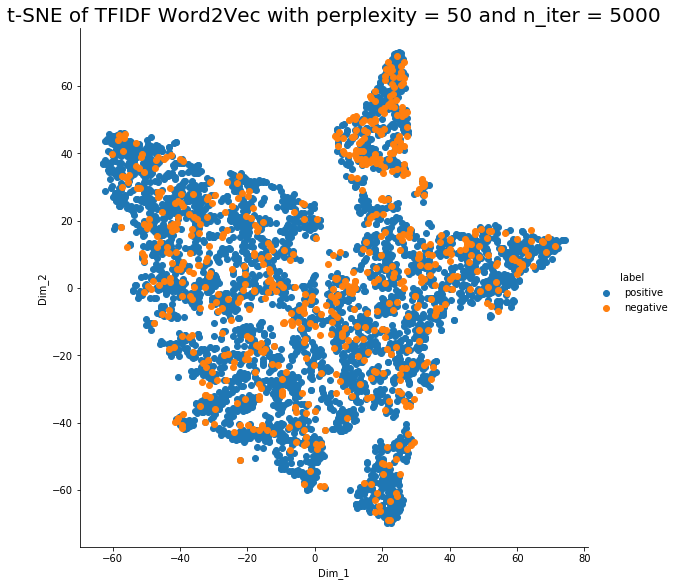

In [50]:
from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,final_data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TFIDF Word2Vec with perplexity = 50 and n_iter = 5000',size=20)
plt.show()

Observations: So as you can see from above plot the datas are overlapping but compare to remaining above plot it is much better. 